In [ ]:
!pip install supervision
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.2/922.2 kB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-

In [ ]:
from ultralytics import YOLO
import cv2
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import time
import supervision as sv

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


3.1.1 Draw the segmentation mask of the largest car: Use ultralytics library only

In [ ]:
img = cv2.imread('/content/drive/MyDrive/cars1.jpg')

In [ ]:
model = YOLO("yolov8n-seg.pt")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
results = model(img)


0: 416x640 14 cars, 236.2ms
Speed: 5.6ms preprocess, 236.2ms inference, 41.5ms postprocess per image at shape (1, 3, 416, 640)


In [ ]:

# Initialize variables for finding the largest box
max_area = 0
largest_box_index = -1

# Iterate through detected objects
for i, box in enumerate(results[0].boxes):
    x1, y1, x2, y2 = box.xyxy[0].int().cpu().numpy()  # Get bounding box coordinates
    area = (x2 - x1) * (y2 - y1)  # area calculation

    # Check if this is the largest detected car
    if area > max_area:
        max_area = area
        largest_box_index = i

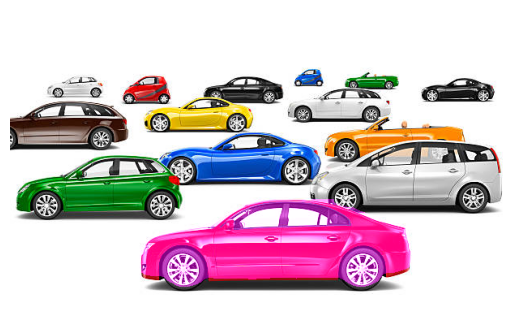

In [ ]:
# Draw the mask of the largest detected car
if largest_box_index != -1:
    mask = results[0].masks.data[largest_box_index].cpu().numpy()

    # Resize mask if necessary
    if mask.shape != img.shape[:2]:
        mask = cv2.resize(mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Create a color mask
    color_mask = np.zeros_like(img)
    color_mask[mask.astype(bool)] = [0, 0, 255]

    # Blend the mask with the image
    img = cv2.addWeighted(img, 1, color_mask, 0.5, 0)

# Display result
plt.imshow(img)
plt.axis("off")
plt.show()

3.1.2 Draw the segmentation mask of the largest car : Use ultralytics + supervision libraries

In [ ]:
# Transfer ultralytics results to supervision
detections = sv.Detections.from_ultralytics(results[0])

In [ ]:
# Iterate through the masks & find the largest

# Initialize variables for tracking the largest mask
max_area = 0
largest_mask = None

# Iterate through detected masks
for mask in detections.mask:
    # mask is already a NumPy array, so no need for .cpu()
    mask_np = mask  # Use it directly

    # Calculate the area of the mask
    area = np.sum(mask_np)  # Count nonzero pixels in the mask

    # Check if this is the largest detected car
    if area > max_area:
        max_area = area
        largest_mask = mask_np  # Store the largest mask

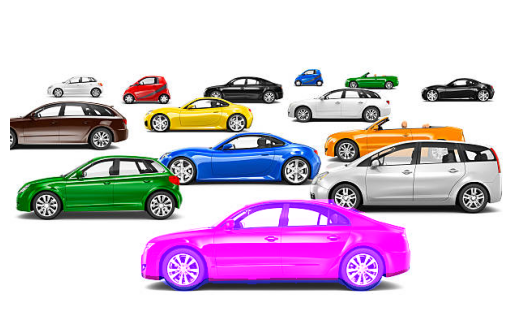

In [ ]:
# Display the largest mask
if largest_mask is not None:
    # Resize mask if necessary
    if largest_mask.shape != img.shape[:2]:
        largest_mask = cv2.resize(largest_mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Create a color mask
    color_mask = np.zeros_like(img)
    color_mask[largest_mask.astype(bool)] = [0, 0, 255]

    # Blend the mask with the image
    img = cv2.addWeighted(img, 1, color_mask, 0.5, 0)

# Display the result
plt.imshow(img)
plt.axis("off")
plt.show()

3.2 Estimate distance to centroid of chair

In [ ]:
import torch
from transformers import pipeline

In [ ]:
# Detect the chair in the image
model = YOLO("yolov8l-seg.pt")
img_path = "/content/drive/MyDrive/chair2.jpeg"
img2 = cv2.imread(img_path)
pil_img = Image.open(img_path)
results = model(pil_img)


0: 640x480 2 bowls, 4 chairs, 1 potted plant, 2798.5ms
Speed: 5.1ms preprocess, 2798.5ms inference, 20.1ms postprocess per image at shape (1, 3, 640, 480)


In [ ]:


# Initialize variables for the largest chair
max_area = 0
largest_chair = None


# Detect the largest chair
for result in results:
    for box in result.boxes:
        class_id = int(box.cls[0])  # Get class ID
        class_name = model.names[class_id]  # Get class name

        if class_name == "chair":  # Check if it's a chair
            x1, y1, x2, y2 = map(int, box.xyxy[0].cpu().numpy())  # Bounding box coordinates
            area = (x2 - x1) * (y2 - y1)  # Compute area

            if area > max_area:
                max_area = area
                largest_chair = (x1, y1, x2, y2)



Largest chair detected at: x=1550, y=2607


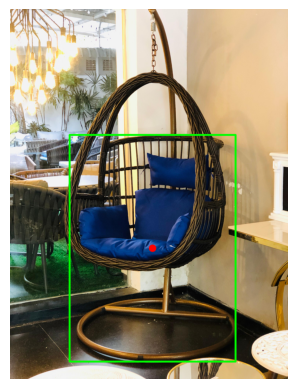

In [ ]:
# calculate centroid and draw
if largest_chair:
    x1, y1, x2, y2 = largest_chair
    centroid_x = (x1 + x2) // 2
    centroid_y = (y1 + y2) // 2

    # Draw bounding box and centroid
    cv2.rectangle(img2, (x1, y1), (x2, y2), (0, 255, 0), 20)
    cv2.circle(img2, (centroid_x, centroid_y), 40, (0, 0, 255), -1)
    print(f"Largest chair detected at: x={centroid_x}, y={centroid_y}")
else:
    print("No chair detected!")

# Display image with bounding box and centroid
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [ ]:
# Obtain the depth map - Depth Anything V2 can be used

# Load Depth Anything V2 model
depth_estimator = pipeline("depth-estimation", model="Intel/dpt-large", device=0 if torch.cuda.is_available() else -1)

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


Estimated distance to chair: 92.00 meters


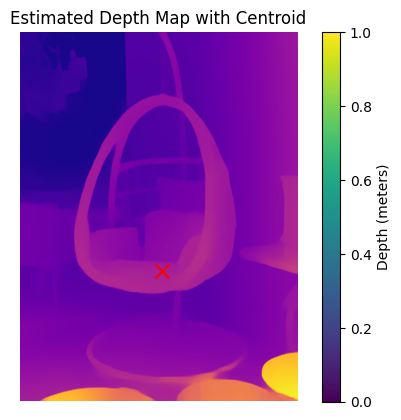

In [ ]:
# Query the value of the depth map at the centroid's location

# Run depth estimation
try:
    depth_map = depth_estimator(pil_img)["depth"]
    depth_np = np.array(depth_map)  # Convert to NumPy array

    # Resize depth map to match image size
    depth_resized = cv2.resize(depth_np, (img2.shape[1], img2.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Query depth at the centroid
    if largest_chair:
        if 0 <= centroid_x < depth_resized.shape[1] and 0 <= centroid_y < depth_resized.shape[0]:
            estimated_distance = depth_resized[centroid_y, centroid_x]
            print(f"Estimated distance to chair: {estimated_distance:.2f} meters")
        else:
            print("Centroid coordinates are outside the depth map dimensions!")

        # Display depth map with centroid
        plt.imshow(depth_resized, cmap="plasma")
        plt.scatter(centroid_x, centroid_y, color="red", marker="x", s=100)  # Mark centroid
        plt.colorbar(label="Depth (meters)")
        plt.title("Estimated Depth Map with Centroid")
        plt.axis("off")
        plt.show()
    else:
        print("No chair detected for depth estimation!")

except Exception as e:
    print(f"Depth estimation failed: {e}")

3.3.1 Draw bounding boxes around the "cars" using supervision.

In [ ]:
# Download the video file from the google drive link, you'll have to "pip install gdown" first
import gdown

file_id = "1zcKvnDDEdyFF4B0B3eYud6DHU19nl0o4"
direct_url = f"https://drive.google.com/uc?id={file_id}"

gdown.download(direct_url, "vehicles_video.mp4", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1zcKvnDDEdyFF4B0B3eYud6DHU19nl0o4
To: /content/vehicles_video.mp4
100%|██████████| 35.3M/35.3M [00:00<00:00, 50.7MB/s]


'vehicles_video.mp4'

In [ ]:
model = YOLO("yolo11n.pt")

# Create Box Annotator
annotator = sv.BoxAnnotator()

def callback(frame: np.ndarray, _: int) -> np.ndarray:
    # Run YOLO on the frame
    results = model(frame)[0]  # Get first result from YOLO

    # Convert YOLO detections to Supervision format
    detections = sv.Detections.from_ultralytics(results)

    # Filter only cars using YOLO's class ID
    CAR_CLASS_ID = 2  # ID from YOLO model's class mappings
    detections = detections[detections.class_id == CAR_CLASS_ID]

    # Draw bounding boxes around detected cars
    annotated_frame = annotator.annotate(
        scene=frame,
        detections=detections
    )

    return annotated_frame

# Process video and save output with bounding boxes
sv.process_video(
    source_path="vehicles_video.mp4",
    target_path="cars_bounding_boxes.mp4",
    callback=callback
                )

print("Bounding boxes around cars added!")

100%|██████████| 5.35M/5.35M [00:00<00:00, 286MB/s]



0: 384x640 3 cars, 1 truck, 52.9ms
Speed: 22.3ms preprocess, 52.9ms inference, 348.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 1 truck, 14.2ms
Speed: 5.3ms preprocess, 14.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 13.9ms
Speed: 5.1ms preprocess, 13.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 19.6ms
Speed: 3.8ms preprocess, 19.6ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 14.5ms
Speed: 3.8ms preprocess, 14.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 15.8ms
Speed: 3.9ms preprocess, 15.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 14.5ms
Speed: 3.8ms preprocess, 14.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 14.7ms
Speed: 3.9ms preprocess, 14.7m

In [ ]:
model = YOLO("yolo11n.pt")

# Initialize ByteTrack tracker
tracker = sv.ByteTrack()

# Create Box Annotator for drawing bounding boxes
annotator = sv.BoxAnnotator()

# Define callback function for video processing
def callback(frame: np.ndarray, _: int) -> np.ndarray:
    # Run YOLO on the frame
    results = model(frame)[0]

    # Convert YOLO detections to Supervision format
    detections = sv.Detections.from_ultralytics(results)

    # Filter only cars using YOLO's class ID (ensure this ID is correct)
    CAR_CLASS_ID = 2
    detections = detections[detections.class_id == CAR_CLASS_ID]

    # Update tracker with car detections
    tracked_detections = tracker.update_with_detections(detections)

    # Annotate frame with bounding boxes
    annotated_frame = annotator.annotate(scene=frame, detections=tracked_detections)

    # Draw tracker ID labels manually
    for (x_min, y_min, x_max, y_max), tracker_id in zip(tracked_detections.xyxy, tracked_detections.tracker_id):
        sv.draw_text(
            scene=annotated_frame,
            text=f"Car ID {tracker_id}",
            text_anchor=sv.Point(int(x_min), int(y_min) - 10),
            text_scale=1,
            text_thickness=2,
            text_color=sv.Color.RED
        )

    return annotated_frame

# Process video and save output
sv.process_video(
    source_path="vehicles_video.mp4",
    target_path="tracked_cars.mp4",
    callback=callback
)

print("Car tracking completed!")


0: 384x640 3 cars, 1 truck, 13.1ms
Speed: 2.8ms preprocess, 13.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 1 truck, 14.7ms
Speed: 3.6ms preprocess, 14.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 13.4ms
Speed: 3.7ms preprocess, 13.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 14.1ms
Speed: 3.9ms preprocess, 14.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 14.5ms
Speed: 3.8ms preprocess, 14.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 17.9ms
Speed: 4.0ms preprocess, 17.9ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 23.9ms
Speed: 4.6ms preprocess, 23.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 26.5ms
Speed: 3.6ms preprocess, 26.5ms i

3.3.2 Draw the track traces for the tracked cars. Use supervision

In [ ]:
# Load YOLO model
model = YOLO("yolo11n.pt")

# Create Tracker (ByteTrack from Supervision)
tracker = sv.ByteTrack()

# Create Box Annotator for bounding boxes and labels
annotator = sv.BoxAnnotator()

# Dictionary to store track traces
track_traces = {}

def callback(frame: np.ndarray, _: int) -> np.ndarray:
    # Run YOLO on the frame
    results = model(frame)[0]

    # Convert YOLO detections to Supervision format
    detections = sv.Detections.from_ultralytics(results)

    # Filter only cars using YOLO's class ID
    CAR_CLASS_ID = 2
    detections = detections[detections.class_id == CAR_CLASS_ID]

    # Update tracker with detections
    tracked_detections = tracker.update_with_detections(detections)

    # Get currently active tracker IDs
    active_ids = set(tracked_detections.tracker_id)

    # Remove traces of cars that are no longer in the frame
    for lost_id in list(track_traces.keys()):
        if lost_id not in active_ids:
            del track_traces[lost_id]

    # Draw bounding boxes with Tracker IDs
    annotated_frame = annotator.annotate(scene=frame, detections=tracked_detections)

    # Store tracking history for traces
    for i, tracker_id in enumerate(tracked_detections.tracker_id):
        x1, y1, x2, y2 = tracked_detections.xyxy[i]  # Bounding box coordinates

        # Compute the center of the bounding box
        center = (int((x1 + x2) / 2), int((y1 + y2) / 2))

        # Initialize tracking history if new tracker ID
        if tracker_id not in track_traces:
            track_traces[tracker_id] = []

        # Append the latest position
        track_traces[tracker_id].append(center)

        # Limit the length of stored tracking traces
        track_traces[tracker_id] = track_traces[tracker_id][-100:]

    # Draw tracking traces
    for tracker_id, trace in track_traces.items():
        for j in range(1, len(trace)):
            if trace[j - 1] is None or trace[j] is None:
                continue
            cv2.line(annotated_frame, trace[j - 1], trace[j], (0, 255, 0), 3)  # Green trace lines

    # Draw Tracker IDs on cars
    for i, tracker_id in enumerate(tracked_detections.tracker_id):
        x1, y1, _, _ = tracked_detections.xyxy[i]  # Bounding box coordinates

        # Position text above the car
        text_position = (int(x1), int(y1) - 10)

        # Draw tracker ID using OpenCV
        cv2.putText(
            annotated_frame,
            f"ID {tracker_id}",
            text_position,
            cv2.FONT_HERSHEY_SIMPLEX,
            1.0,  # Font size
            (0, 0, 255),  # Text color (Red)
            2,  # Thickness
            cv2.LINE_AA
        )

    return annotated_frame

# Process video and save output
sv.process_video(
    source_path="vehicles_video.mp4",
    target_path="tracked_cars_with_ids.mp4",
    callback=callback
)

print("Car tracking with Tracker IDs & traces completed! Output saved as 'tracked_cars_with_ids.mp4'.")


0: 384x640 3 cars, 1 truck, 8.7ms
Speed: 2.4ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 1 truck, 14.9ms
Speed: 3.9ms preprocess, 14.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 14.9ms
Speed: 3.7ms preprocess, 14.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 14.8ms
Speed: 3.7ms preprocess, 14.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 15.2ms
Speed: 4.7ms preprocess, 15.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 14.9ms
Speed: 3.6ms preprocess, 14.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 19.7ms
Speed: 4.7ms preprocess, 19.7ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 15.0ms
Speed: 3.8ms preprocess, 15.0ms inf

Question: Explain what "def callback(frame: np.ndarray, _: int) -> np.ndarray:" does.

In [ ]:
def callback(frame: np.ndarray, _: int) -> np.ndarray:


This function is a callback function used during video processing.

* **frame: np.ndarray** → The function takes a video frame (a NumPy array representing an image).
* **: int** → This parameter represents the frame index but is not used ( is a common convention to indicate an unused variable).

* **-> np.ndarray** → The function returns a processed video frame as a NumPy array (image data).


This function is used in sv.process_video(), which processes each frame of the input video by:

    Detecting Cars using YOLO

    Tracking Vehicles using Supervision’s ByteTrack

    Drawing Bounding Boxes around detected cars

    Adding Tracking IDs and Traces to track movement over time

    Returning the Processed Frame for inclusion in the final output video



Output videos: https://drive.google.com/drive/folders/1flWNmrKJDgZnnS_YkaBanXi0ZDl-QgJH?usp=sharing